In [3]:
# TensorFlow and tf.keras
import tensorflow as tf
import keras
import sys
import logging
sys.path.insert(0, '../')

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

print(tf.__version__)

Using TensorFlow backend.


1.13.1


In [4]:
!python --version

Python 2.7.16


In [5]:
logging.basicConfig(filename='results.log')

logger = logging.getLogger('stab.gen.expt')
handler = logging.FileHandler('results.log')
handler.setLevel(logging.DEBUG)
logger.addHandler(handler)

In [6]:
logger.warning('Hey, it is good!')

### Import the MNIST dataset/ Preprocess the data

In [7]:
mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [8]:
x_train = x_train/255
x_test = x_test/255

In [9]:
num_classes = 10

In [10]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

### Train and test the network on MNIST

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Dropout, Flatten

In [12]:
from adv_util import create_fully_connected

In [13]:
def flatten_mnist(x):
    n, img_rows, img_cols = x.shape
    D = img_rows * img_cols
    x_flattened = x.reshape(n, D)
    return x_flattened, (D, )

In [14]:
def evaluate_on_both(model, x_test_flat, y_test, corrupt_func):
    loss_benign, acc_benign = model.evaluate(x_test_flat, y_test, verbose=False)
    x_test_corrupt = corrupt_data(x_test, x_test.shape[0], corrupt_func)
    x_test_corrupt_flat, _ = flatten_mnist(x_test_corrupt)
    loss_corrupt, acc_corrupt = model.evaluate(x_test_corrupt_flat, y_test, verbose=False)
    return (loss_benign, acc_benign, loss_corrupt, acc_corrupt)                               

In [15]:
def compile_train_test(x_train, y_train, x_test, y_test, reg = 1e-3, corrupt_func = None, frac = 0.4):
    
    #Config
    num_classes = 10
    
    x_train_flat, input_shape = flatten_mnist(x_train)
    x_test_flat, _ = flatten_mnist(x_test)
    
    print("Frac value:" + str(frac))
    
    
    #Fit regular data
    model = create_fully_connected(input_shape = input_shape, num_classes = num_classes, reg = reg)
    model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train_flat, y_train, batch_size=128, epochs=15, verbose=True, validation_split=.1)
    loss_benign, acc_benign, loss_corrupt, acc_corrupt = evaluate_on_both(model, x_test_flat, y_test, corrupt_func)
    
   
    #Fit corrupted data
    model = create_fully_connected(input_shape = input_shape, num_classes = num_classes, reg = reg)
    model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
    x_train_corrupt = corrupt_data(x_train, int(np.round(frac*x_train.shape[0])), corrupt_func)
    x_train_corrupt_flat, _ = flatten_mnist(x_train_corrupt)
    model.fit(x_train_corrupt_flat, y_train, batch_size=128, epochs=15, verbose=True, validation_split=.1)
    
    loss_benign_poison, acc_benign_poison, loss_corrupt_poison, acc_corrupt_poison = evaluate_on_both(model, x_test_flat, y_test, corrupt_func)
    
    
    #Stab and generalization quantities
    x_loss = loss_benign_poison - loss_benign
    x_acc = acc_benign_poison - acc_benign
    y_loss = loss_corrupt - loss_benign
    y_acc = acc_corrupt - acc_benign
    
    logging.info('Reg: %s Corruption: %s Frac_corrupt: %s Stability_loss %s Stability_acc %s Gen_loss %s Gen_acc %s'
                    % (reg, str(corrupt_func), frac, x_loss, x_acc, y_loss, y_acc))
    
    
    return x_loss, x_acc, y_loss, y_acc

## Blurring test

In [16]:
from mnist_corruption import gaussian_blurring, corrupt_data, random_perturbation, random_blackout_whiteout

In [17]:
x_small = x_train[0:5]

x_corrupted_small = corrupt_data(x_small, int(np.round(0.4 * x_small.shape[0])), random_perturbation)
x_corrupted_reshaped = x_corrupted_small.reshape((x_corrupted_small.shape[0], 784))

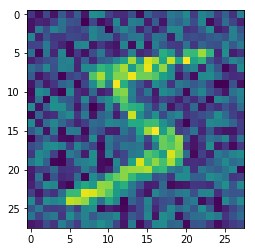

In [18]:
plt.imshow(x_corrupted_small[0])

In [19]:
print(y_train[0:5])

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


# Stability and Generalization

In [20]:
from adv_util import create_fully_connected

In [27]:
reg_array = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
diff_loss_lst = []
diff_acc_lst = []
acc_corrupt_lst = []
loss_corrupt_lst =[]

for reg in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]:
    diff_loss, diff_acc, loss_test_corrupt, accuracy_test_corrupt = compile_train_test(x_train, y_train, x_test, y_test, reg = reg, corrupt_func = random_blackout_whiteout)
    diff_loss_lst.append(diff_loss)
    diff_acc_lst.append(diff_acc)
    acc_corrupt_lst.append(accuracy_test_corrupt)
    loss_corrupt_lst.append(loss_test_corrupt)


Frac value:0.4
Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - 2s - loss: 2.3174 - acc: 0.1465 - val_loss: 2.2753 - val_acc: 0.2632
Epoch 2/15
54000/54000 [==============================] - 1s - loss: 2.2628 - acc: 0.2193 - val_loss: 2.2468 - val_acc: 0.2967
Epoch 3/15
54000/54000 [==============================] - 0s - loss: 2.2321 - acc: 0.3134 - val_loss: 2.2114 - val_acc: 0.4338
Epoch 4/15
54000/54000 [==============================] - 0s - loss: 2.1932 - acc: 0.4188 - val_loss: 2.1660 - val_acc: 0.4877
Epoch 5/15
54000/54000 [==============================] - 0s - loss: 2.1421 - acc: 0.4839 - val_loss: 2.1059 - val_acc: 0.5322
Epoch 6/15
54000/54000 [==============================] - 0s - loss: 2.0757 - acc: 0.5238 - val_loss: 2.0291 - val_acc: 0.5733
Epoch 7/15
54000/54000 [==============================] - 0s - loss: 1.9923 - acc: 0.5538 - val_loss: 1.9350 - val_acc: 0.6048
Epoch 8/15
54000/54000 [=======================

54000/54000 [==============================] - 0s - loss: 2.3427 - acc: 0.2978 - val_loss: 2.3243 - val_acc: 0.4162
Epoch 4/15
54000/54000 [==============================] - 0s - loss: 2.3090 - acc: 0.3987 - val_loss: 2.2860 - val_acc: 0.4723
Epoch 5/15
54000/54000 [==============================] - 0s - loss: 2.2667 - acc: 0.4660 - val_loss: 2.2370 - val_acc: 0.5148
Epoch 6/15
54000/54000 [==============================] - 0s - loss: 2.2131 - acc: 0.5066 - val_loss: 2.1756 - val_acc: 0.5563
Epoch 7/15
54000/54000 [==============================] - 0s - loss: 2.1466 - acc: 0.5364 - val_loss: 2.1005 - val_acc: 0.5887
Epoch 8/15
54000/54000 [==============================] - 0s - loss: 2.0677 - acc: 0.5615 - val_loss: 2.0137 - val_acc: 0.5953
Epoch 9/15
54000/54000 [==============================] - 0s - loss: 1.9796 - acc: 0.5799 - val_loss: 1.9192 - val_acc: 0.6217
Epoch 10/15
54000/54000 [==============================] - 0s - loss: 1.8863 - acc: 0.5906 - val_loss: 1.8206 - val_acc: 0

54000/54000 [==============================] - 0s - loss: 2.3013 - acc: 0.1132 - val_loss: 2.3021 - val_acc: 0.1050
Epoch 8/15
54000/54000 [==============================] - 0s - loss: 2.3013 - acc: 0.1132 - val_loss: 2.3021 - val_acc: 0.1050
Epoch 9/15
54000/54000 [==============================] - 0s - loss: 2.3013 - acc: 0.1132 - val_loss: 2.3021 - val_acc: 0.1050
Epoch 10/15
54000/54000 [==============================] - 0s - loss: 2.3013 - acc: 0.1132 - val_loss: 2.3022 - val_acc: 0.1050
Epoch 11/15
54000/54000 [==============================] - 0s - loss: 2.3013 - acc: 0.1132 - val_loss: 2.3021 - val_acc: 0.1050
Epoch 12/15
54000/54000 [==============================] - 0s - loss: 2.3013 - acc: 0.1132 - val_loss: 2.3021 - val_acc: 0.1050
Epoch 13/15
54000/54000 [==============================] - 0s - loss: 2.3013 - acc: 0.1132 - val_loss: 2.3022 - val_acc: 0.1050
Epoch 14/15
54000/54000 [==============================] - 0s - loss: 2.3013 - acc: 0.1132 - val_loss: 2.3022 - val_ac

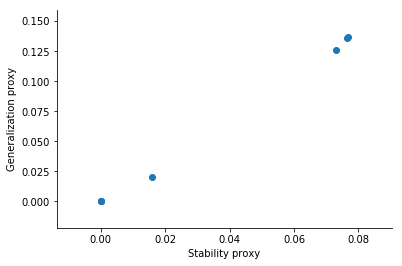

In [28]:
diff_loss_lst = [np.abs(x) for x in diff_loss_lst]
loss_corrupt_lst = [np.abs(x) for x in loss_corrupt_lst]

plt.scatter(diff_loss_lst, loss_corrupt_lst)
plt.xlabel('Poisoning Loss - Test loss')
plt.ylabel('Corruption Test Loss - Test Loss')


plt.xlabel('Stability proxy')
plt.ylabel('Generalization proxy')

ax = plt.subplot(111)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

"""
for k in range(len(reg_array)):
    reg_val = reg_array[k]
    x = diff_loss_lst[k]
    y = loss_corrupt_lst[k]
    plt.annotate(reg_val, xy=(x, y), xytext=(-0.5, 0.5), textcoords='offset points', ha='right', va='bottom')
"""    

plt.savefig('images/reg_new/random_blackwhite_loss_new.png')
plt.show()

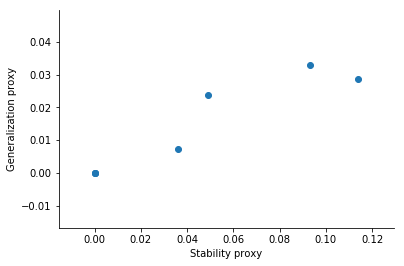

<Figure size 432x288 with 0 Axes>

In [26]:
diff_acc_lst = [np.abs(x) for x in diff_acc_lst]
acc_corrupt_lst = [np.abs(x) for x in acc_corrupt_lst]

ax = plt.subplot(111)

plt.scatter(diff_acc_lst, acc_corrupt_lst)
plt.xlabel('Stability proxy')
plt.ylabel('Generalization proxy')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.show()

"""
for k in range(len(reg_array)):
    reg_val = reg_array[k]
    x = diff_acc_lst[k]
    y = acc_corrupt_lst[k]
    plt.annotate(reg_val, xy=(x, y), xytext=(-20, 20), textcoords='offset points', ha='right', va='bottom')
"""

plt.savefig('random_blackwhite_acc.png')

# How does benign test loss scale with fraction of training set corrupted?

In [77]:
frac_array = np.arange(0.1, 1.0, 0.1)
loss_benign_poison_lst, acc_benign_poison_lst, loss_corrupt_poison_lst, acc_corrupt_poison_lst = [], [], [], []

for frac in frac_array:
    loss_benign_poison, acc_benign_poison, loss_corrupt_poison, acc_corrupt_poison = compile_train_test(x_train, y_train, x_test, y_test, corrupt_func = random_blackout_whiteout, frac = frac)
    loss_benign_poison_lst.append(loss_benign_poison)
    acc_benign_poison_lst.append(acc_benign_poison)
    loss_corrupt_poison_lst.append(loss_corrupt_poison)
    acc_corrupt_poison_lst.append(acc_corrupt_poison)

Frac value:0.1
Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - 2s 45us/step - loss: 2.4256 - acc: 0.1459 - val_loss: 2.3832 - val_acc: 0.2612
Epoch 2/15
54000/54000 [==============================] - 1s 18us/step - loss: 2.3710 - acc: 0.2123 - val_loss: 2.3559 - val_acc: 0.2808
Epoch 3/15
54000/54000 [==============================] - 1s 18us/step - loss: 2.3427 - acc: 0.2978 - val_loss: 2.3243 - val_acc: 0.4162
Epoch 4/15
54000/54000 [==============================] - 1s 18us/step - loss: 2.3090 - acc: 0.3987 - val_loss: 2.2859 - val_acc: 0.4723
Epoch 5/15
54000/54000 [==============================] - 1s 16us/step - loss: 2.2666 - acc: 0.4660 - val_loss: 2.2370 - val_acc: 0.5148
Epoch 6/15
54000/54000 [==============================] - 1s 19us/step - loss: 2.2131 - acc: 0.5066 - val_loss: 2.1756 - val_acc: 0.5563
Epoch 7/15
54000/54000 [==============================] - 1s 17us/step - loss: 2.1466 - acc: 0.5364 - val_loss: 2.

Epoch 14/15
54000/54000 [==============================] - 1s 16us/step - loss: 1.5952 - acc: 0.6501 - val_loss: 1.5261 - val_acc: 0.6882
Epoch 15/15
54000/54000 [==============================] - 1s 16us/step - loss: 1.5234 - acc: 0.6697 - val_loss: 1.4543 - val_acc: 0.7118
Frac value:0.30000000000000004
Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - 2s 40us/step - loss: 2.4256 - acc: 0.1459 - val_loss: 2.3832 - val_acc: 0.2612
Epoch 2/15
54000/54000 [==============================] - 1s 16us/step - loss: 2.3710 - acc: 0.2123 - val_loss: 2.3559 - val_acc: 0.2808
Epoch 3/15
54000/54000 [==============================] - 1s 16us/step - loss: 2.3427 - acc: 0.2978 - val_loss: 2.3243 - val_acc: 0.4162
Epoch 4/15
54000/54000 [==============================] - 1s 16us/step - loss: 2.3090 - acc: 0.3987 - val_loss: 2.2859 - val_acc: 0.4723
Epoch 5/15
54000/54000 [==============================] - 1s 16us/step - loss: 2.2666 - acc: 0.4

Epoch 12/15
54000/54000 [==============================] - 1s 17us/step - loss: 1.8139 - acc: 0.5976 - val_loss: 1.7507 - val_acc: 0.6352
Epoch 13/15
54000/54000 [==============================] - 1s 17us/step - loss: 1.7300 - acc: 0.6174 - val_loss: 1.6650 - val_acc: 0.6537
Epoch 14/15
54000/54000 [==============================] - 1s 17us/step - loss: 1.6510 - acc: 0.6348 - val_loss: 1.5851 - val_acc: 0.6667
Epoch 15/15
54000/54000 [==============================] - 1s 17us/step - loss: 1.5781 - acc: 0.6513 - val_loss: 1.5119 - val_acc: 0.6880
Frac value:0.5
Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - 2s 43us/step - loss: 2.4256 - acc: 0.1459 - val_loss: 2.3832 - val_acc: 0.2612
Epoch 2/15
54000/54000 [==============================] - 1s 17us/step - loss: 2.3710 - acc: 0.2123 - val_loss: 2.3559 - val_acc: 0.2808
Epoch 3/15
54000/54000 [==============================] - 1s 16us/step - loss: 2.3427 - acc: 0.2978 - val_loss

Epoch 10/15
54000/54000 [==============================] - 1s 17us/step - loss: 2.0315 - acc: 0.5354 - val_loss: 1.9817 - val_acc: 0.5768
Epoch 11/15
54000/54000 [==============================] - 1s 18us/step - loss: 1.9513 - acc: 0.5601 - val_loss: 1.8963 - val_acc: 0.5965
Epoch 12/15
54000/54000 [==============================] - 1s 17us/step - loss: 1.8685 - acc: 0.5805 - val_loss: 1.8096 - val_acc: 0.6115
Epoch 13/15
54000/54000 [==============================] - 1s 17us/step - loss: 1.7861 - acc: 0.5954 - val_loss: 1.7249 - val_acc: 0.6332
Epoch 14/15
54000/54000 [==============================] - 1s 17us/step - loss: 1.7073 - acc: 0.6181 - val_loss: 1.6449 - val_acc: 0.6430
Epoch 15/15
54000/54000 [==============================] - 1s 18us/step - loss: 1.6336 - acc: 0.6336 - val_loss: 1.5704 - val_acc: 0.6638
Frac value:0.7000000000000001
Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - 2s 44us/step - loss: 2.4256 - acc: 

Epoch 8/15
54000/54000 [==============================] - 1s 18us/step - loss: 2.2017 - acc: 0.4784 - val_loss: 2.1685 - val_acc: 0.5285
Epoch 9/15
54000/54000 [==============================] - 1s 19us/step - loss: 2.1434 - acc: 0.5035 - val_loss: 2.1037 - val_acc: 0.5410
Epoch 10/15
54000/54000 [==============================] - 1s 20us/step - loss: 2.0757 - acc: 0.5237 - val_loss: 2.0297 - val_acc: 0.5540
Epoch 11/15
54000/54000 [==============================] - 1s 21us/step - loss: 2.0010 - acc: 0.5399 - val_loss: 1.9495 - val_acc: 0.5858
Epoch 12/15
54000/54000 [==============================] - 1s 22us/step - loss: 1.9222 - acc: 0.5597 - val_loss: 1.8662 - val_acc: 0.5977
Epoch 13/15
54000/54000 [==============================] - 1s 17us/step - loss: 1.8422 - acc: 0.5799 - val_loss: 1.7832 - val_acc: 0.6150
Epoch 14/15
54000/54000 [==============================] - 1s 19us/step - loss: 1.7638 - acc: 0.5969 - val_loss: 1.7029 - val_acc: 0.6302
Epoch 15/15
54000/54000 [===========

### Create the plots 

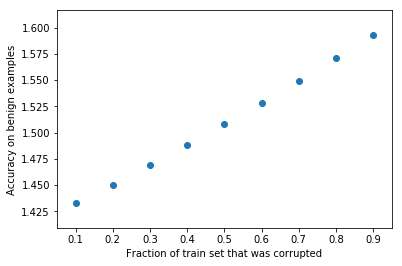

In [81]:
ax = plt.subplot(111)

ax.scatter(frac_array, loss_benign_poison_lst)
plt.ylabel('Loss on benign examples')
plt.xlabel('Fraction of train set that was corrupted')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

#plt.savefig('Random_blackout_whiteout_loss.png')
plt.show()

In [82]:
diff_array = []
for i in range(1, len(frac_array)):
    diff_array.append(acc_corrupt_poison_lst[i] - acc_corrupt_poison_lst[i-1])

In [83]:
diff_array

[0.0009000000000000119,
 -0.00660000000000005,
 -0.012399999999999967,
 -0.01429999999999998,
 -0.0049000000000000155,
 -0.010000000000000009,
 -0.0004999999999999449,
 -0.016300000000000092]

## What happens to the test accuracy on corrupted points when % corrupted in train set increases?

In [22]:
from mnist_corruption import gaussian_blurring, corrupt_data, random_perturbation, random_blackout_whiteout

In [54]:
#Define a function that inputs frac_corrupted as a parameter and outputs test accuracy on fully corrupted points.
def train_and_report(x_train, y_train, x_test, y_test, reg = 1e-3, corrupt_func = None, frac = 0.4):
    
    #Config
    num_classes = 10
    
    x_train_flat, input_shape = flatten_mnist(x_train)
    x_test_flat, _ = flatten_mnist(x_test)
    
    print("Frac value:" + str(frac))
   
    #Fit corrupted data
    model = create_fully_connected(input_shape = input_shape, num_classes = num_classes, reg = reg)
    model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
    x_train_corrupt = corrupt_data(x_train, int(np.round(frac*x_train.shape[0])), corrupt_func)
    x_train_corrupt_flat, _ = flatten_mnist(x_train_corrupt)
    
    
    model.fit(x_train_flat, y_train, batch_size=128, epochs=15, verbose=True, validation_split=.1)
    
    _, _, loss_corrupt_poison, acc_corrupt_poison = evaluate_on_both(model, x_test_flat, y_test, corrupt_func)
    
    return loss_corrupt_poison, acc_corrupt_poison

In [56]:
frac_array = np.arange(0.1, 1.0, 0.2)
loss_corrupt_poison_lst, acc_corrupt_poison_lst = [], []
for frac in frac_array:
    loss_corrupt_poison, acc_corrupt_poison = train_and_report(x_train, y_train, x_test, y_test, corrupt_func = random_perturbation, frac = frac)
    loss_corrupt_poison_lst.append(loss_corrupt_poison)
    acc_corrupt_poison_lst.append(acc_corrupt_poison)

Frac value:0.1
Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - 1s 21us/step - loss: 2.4370 - acc: 0.0841 - val_loss: 2.3918 - val_acc: 0.1065
Epoch 2/15
54000/54000 [==============================] - 1s 14us/step - loss: 2.3791 - acc: 0.1721 - val_loss: 2.3657 - val_acc: 0.2062
Epoch 3/15
54000/54000 [==============================] - 1s 14us/step - loss: 2.3531 - acc: 0.2457 - val_loss: 2.3380 - val_acc: 0.3015
Epoch 4/15
54000/54000 [==============================] - 1s 13us/step - loss: 2.3237 - acc: 0.3454 - val_loss: 2.3048 - val_acc: 0.3697
Epoch 5/15
54000/54000 [==============================] - 1s 15us/step - loss: 2.2877 - acc: 0.3966 - val_loss: 2.2635 - val_acc: 0.4925
Epoch 6/15
54000/54000 [==============================] - 1s 15us/step - loss: 2.2422 - acc: 0.4695 - val_loss: 2.2114 - val_acc: 0.5113
Epoch 7/15
54000/54000 [==============================] - 1s 14us/step - loss: 2.1846 - acc: 0.4934 - val_loss: 2.

In [19]:
plt.scatter(frac_array, acc_corrupt_poison_lst)
plt.xlabel('Fraction of training set corrupted')
plt.ylabel('Accuracy on benign of model trained on corrupted')

NameError: name 'frac_array' is not defined

# How does correlation change with frac of training corrupted?

In [86]:
import scipy as sp

In [109]:
frac_array = np.arange(0.1, 1.0, 0.2)
reg_array = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

loss_pearson = []
acc_pearson = []
sg_dict = {}


for frac in frac_array:
    loss_stab_proxy, loss_gen_proxy, acc_stab_proxy, acc_gen_proxy = [], [], [], []
    
    for reg in reg_array:
        x_loss, x_acc, y_loss, y_acc = compile_train_test(x_train, y_train, x_test, y_test, corrupt_func = gaussian_blurring, reg = reg, frac = frac)
        loss_stab_proxy.append(x_loss)
        acc_stab_proxy.append(x_acc)
        loss_gen_proxy.append(y_loss)
        acc_gen_proxy.append(y_acc)
    
    sg_dict[frac] = (loss_stab_proxy, loss_gen_proxy)
    
    loss_corr, _ = sp.stats.pearsonr(loss_stab_proxy, loss_gen_proxy)
    acc_corr, _ = sp.stats.pearsonr(acc_stab_proxy, acc_gen_proxy)
    
    loss_pearson.append(loss_corr)
    acc_pearson.append(acc_corr)
    

Frac value:0.1
Train on 54000 samples, validate on 6000 samples
Epoch 1/15


KeyboardInterrupt: 

In [94]:
print(loss_pearson)

[0.9978624801068675, 0.9980280247906131, 0.9980988564012216, 0.9981658578130178, 0.9981684373467914]


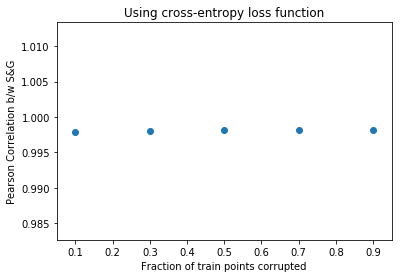

In [107]:
plt.scatter(frac_array, loss_pearson)
plt.xlabel('Fraction of train points corrupted')
plt.ylabel('Pearson Correlation b/w S&G')
plt.title('Using cross-entropy loss function')
plt.savefig('./images/corr/loss_pearson.png')

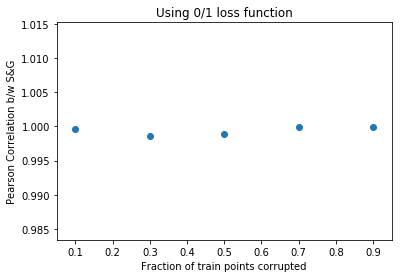

In [108]:
plt.scatter(frac_array, acc_pearson)
plt.xlabel('Fraction of train points corrupted')
plt.ylabel('Pearson Correlation b/w S&G')
plt.title('Using 0/1 loss function')
plt.savefig('./images/corr/acc_pearson.png')

In [105]:
frac_array = np.arange(0.1, 1.0, 0.2)
x, y = sg_dict[]
plt.scatter(x,y)

KeyError: 0.5000000000000001